# Set GPU runtime
- [참고] https://github.com/kmsravindra/ML-AI-experiments/blob/master/AI/knowledge_distillation/Knowledge%20distillation.ipynb

# Knowledge Distillation 


<center><img src='https://github.com/karanchahal/distiller/raw/master/distiller.jpg' width=30%></center>




# Experiments 


<center><img src='https://github.com/hoesungryu/lightweight_toyexample/blob/master/imgs/knowledge_distillation.jpg?raw=true', width=60%></center>

In [ ]:
# Google Drive Mount 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torchsummary import summary

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

# Path 설정 
import os
os.chdir('/content/gdrive/My Drive/') # DataPath
current_path = os.getcwd() # current folder

In [ ]:
# user-define function 

# Training
def train(epoch,net):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx %1000 ==0:
            print('Loss: %.3f | Acc: %.3f%% ' %(train_loss/(batch_idx+1),100.*correct/total))
    
def train_distillation(epoch, student, teacher, TEMPERATURE, ALPHA):
    print('\nEpoch: %d' % epoch)
    student.train()
    teacher.eval()
    
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = student(inputs) # student
        teacher_outputs = teacher(inputs) # teacher 

        loss = loss_fn_kd(outputs, targets, teacher_outputs,TEMPERATURE,ALPHA)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx %1000 ==0:
            print('Loss: %.3f | Acc: %.3f%% ' %(train_loss/(batch_idx+1),100.*correct/total))
     
    
def test(epoch,net):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

def loss_fn_kd(outputs, labels, teacher_outputs, T=2, alpha=0.5):
    """
    # outputs = result of model
    # labels = true label 
    # teacher_outputs = teacher_model(data) # teacher model eval()
    # params = T & alpha 
    """
    KD_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                                F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
                F.cross_entropy(outputs, labels) * (1. - alpha)



    return KD_loss

In [ ]:
# Initial Value 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BEST_ACC = 0 
START_EPOCH = 0 # start from epoch 0 or last checkpoint epoch
BATCH_SIZE = 16


In [ ]:
# Data preprocessing
print('==> Preparing data..')

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transform_train = transforms.Compose([transforms.RandomResizedCrop(size=256),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean_nums, std_nums),
])


transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean_nums, std_nums),
])

==> Preparing data..


In [ ]:
# DataSet & DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Check data size 
images, labels = next(iter(trainloader))
print(images.shape)

torch.Size([16, 3, 256, 256])


# STEP 1 
 
 Teacher Network 학습 

 우리는 pretrained 된 resnet34 을 Teacher model 모델로 사용하겠습니다. (pretrained with 1000-class imagenet)
 

<center><img src='https://miro.medium.com/max/1708/1*1CSCPAEhvtBPcjNA9bll0A.png', width=70%></center>
<center> <em>ResNet34의 구조</em></center>

In [ ]:
# teacher 
teacher = models.__dict__['resnet34'](pretrained=True)
for param in teacher.parameters():
    param.requires_grad = False
    
in_features = teacher.fc.in_features
teacher.fc = nn.Linear(in_features,10)

# Fine-tuning
for name, child in teacher.named_children():
    if name in ['layer3', 'layer4','fc']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

teacher = teacher.to(DEVICE)
summary(teacher,(3,256, 256))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



layer3has been unfrozen.
layer4has been unfrozen.
fchas been unfrozen.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=1e-3,
                      momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# RUN 
for epoch in range(START_EPOCH,START_EPOCH+20):
    train(epoch,teacher)
    test(epoch,teacher)
    exp_lr_scheduler.step()
    torch.save(teacher.state_dict(), f'./teacher_{epoch}.pth')


Epoch: 0
Loss: 2.398 | Acc: 6.250% 
Loss: 1.157 | Acc: 59.634% 
Loss: 1.012 | Acc: 64.886% 
Loss: 0.941 | Acc: 67.363% 
Accuracy of the network on the test images: 91 %

Epoch: 1
Loss: 0.590 | Acc: 81.250% 
Loss: 0.729 | Acc: 74.719% 
Loss: 0.709 | Acc: 75.587% 
Loss: 0.696 | Acc: 75.987% 
Accuracy of the network on the test images: 92 %

Epoch: 2
Loss: 0.287 | Acc: 87.500% 
Loss: 0.647 | Acc: 77.635% 
Loss: 0.640 | Acc: 77.805% 
Loss: 0.629 | Acc: 78.193% 
Accuracy of the network on the test images: 92 %

Epoch: 3
Loss: 0.425 | Acc: 81.250% 
Loss: 0.605 | Acc: 79.283% 
Loss: 0.595 | Acc: 79.673% 
Loss: 0.590 | Acc: 79.630% 
Accuracy of the network on the test images: 92 %

Epoch: 4
Loss: 0.859 | Acc: 62.500% 
Loss: 0.554 | Acc: 80.925% 
Loss: 0.560 | Acc: 80.728% 
Loss: 0.552 | Acc: 80.988% 
Accuracy of the network on the test images: 93 %

Epoch: 5
Loss: 0.732 | Acc: 75.000% 
Loss: 0.543 | Acc: 81.063% 
Loss: 0.532 | Acc: 81.506% 
Loss: 0.531 | Acc: 81.510% 
Accuracy of the network 

In [ ]:
torch.save(teacher.state_dict(), f'./teacher_{epoch}.pth')

# Teacher (ResNet34)의 예측 분포 살펴보기 

이번 섹션은 학습 된 Teacher Network 를 가지고 특정 샘플을 예측한 분포를 살펴보도록 하겠습니다. 


In [ ]:
# Model Load 
DICT_PATH = f'./teacher_{epoch}.pth'
teacher.load_state_dict(torch.load(DICT_PATH))

# freeze
for param in teacher.parameters():
    param.requires_grad = False
    
teacher.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Select one single image 
import matplotlib.pyplot as plt 
import numpy as np 
select_num = int(input())
selected_images = testset.__getitem__(select_num)[0] # img
selected_labels = testset.__getitem__(select_num)[1]  #label

0


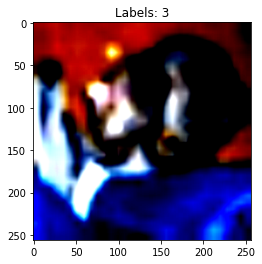

In [ ]:
# display 
img = selected_images # selected img
img = np.moveaxis(img.numpy(), 0, -1) # reshape and moveaxis 

plt.figure(figsize=(4,4))
plt.title('Labels: {}'.format(selected_labels))
plt.imshow(np.clip(img, 0, 1))
plt.show()

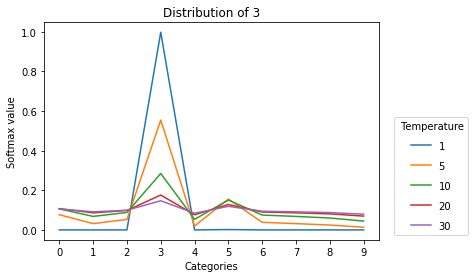

In [ ]:
import pandas as pd
# Check distribution
teacher_outputs = teacher(torch.unsqueeze(selected_images, 0).to(DEVICE))

# list of Temperature 
T_list = [1,5,10,20,30]
output_dic ={}

for i in T_list:
  output_dic[i] = F.softmax(teacher_outputs/i, dim=1).cpu().numpy().squeeze() # softmax

# display
pd.DataFrame(output_dic).plot(title=f'Distribution of {selected_labels}')
plt.legend(title=' Temperature', labelspacing=1, 
           bbox_to_anchor=(1.03,0), loc='lower left')
plt.xlabel('Categories')
plt.ylabel('Softmax value')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()                                             

# STEP 2

앞서 학습된 Teacher Network를 가지고 Student Network 에 KD(knowledge distillation)을 하는 단계입니다. 
여기서 Student Network 는 'ResNet18'을 사용 하겠습니다. 


<center><img src='https://www.programmersought.com/images/67/f941fa481a9d8987b5022f1a8bade653.png' width=50%></center>
<center> <em>ResNet18의 구조</em></center>



*여기서 잠깐 복습*

$$ L(x;w) = \alpha * KL(teacher, student) + (1-\alpha)*Cross-Entropy(y,student)$$

본 단계에서의 변수는 다음과 같이 설정 하도록 하겠습니다. 
```
Teacher: ResNet34(pretrained)
Student: ResNet18
Alpha = 0.3 
Temperature = 2 # KD divergence ratio
```

In [ ]:
# ALPHA & TEMPERATURE 
TEMPERATURE = 2
ALPHA = 0.3 

In [ ]:
# Load Teacher dict 
DICT_PATH = 'teacher_19.pth'

teacher.load_state_dict(torch.load(DICT_PATH,))
for param in teacher.parameters():
    param.requires_grad = False
    
teacher.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
student = models.__dict__['resnet18']()
in_features = student.fc.in_features
student.fc = nn.Linear(in_features,10)


student.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)

In [ ]:
print('[INFO] START KD')
print('- KD temperature {}'.format(TEMPERATURE))
print('- KD alpha {}'.format(ALPHA))
for epoch in range(0, START_EPOCH+10):
    train_distillation(epoch,student, teacher,TEMPERATURE, ALPHA)
    test(epoch,student)

[INFO] START KD
- KD temperature 2
- KD alpha 0.3

Epoch: 0
Loss: 3.263 | Acc: 18.750% 
Loss: 2.849 | Acc: 25.943% 
Loss: 2.726 | Acc: 29.810% 
Loss: 2.632 | Acc: 32.171% 
Accuracy of the network on the test images: 44 %

Epoch: 1
Loss: 2.903 | Acc: 50.000% 
Loss: 2.307 | Acc: 40.478% 
Loss: 2.240 | Acc: 42.191% 
Loss: 2.186 | Acc: 43.538% 
Accuracy of the network on the test images: 58 %

Epoch: 2
Loss: 2.470 | Acc: 37.500% 
Loss: 1.980 | Acc: 48.795% 
Loss: 1.934 | Acc: 49.884% 
Loss: 1.892 | Acc: 50.939% 
Accuracy of the network on the test images: 58 %

Epoch: 3
Loss: 1.755 | Acc: 50.000% 
Loss: 1.749 | Acc: 54.252% 
Loss: 1.713 | Acc: 54.854% 
Loss: 1.685 | Acc: 55.402% 
Accuracy of the network on the test images: 68 %

Epoch: 4
Loss: 1.511 | Acc: 62.500% 
Loss: 1.576 | Acc: 58.248% 
Loss: 1.556 | Acc: 58.674% 
Loss: 1.539 | Acc: 59.016% 
Accuracy of the network on the test images: 67 %

Epoch: 5
Loss: 1.027 | Acc: 81.250% 
Loss: 1.454 | Acc: 60.770% 
Loss: 1.442 | Acc: 61.048% 
L

In [ ]:
# train student alone
student = models.__dict__['resnet18']()
in_features = student.fc.in_features
student.fc = nn.Linear(in_features,10)


student.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)

print('[INFO] START training student alone')
for epoch in range(0, START_EPOCH+10):
    train(epoch,student)
    test(epoch,student)

[INFO] START training student alone

Epoch: 0
Loss: 2.188 | Acc: 31.250% 
Loss: 1.986 | Acc: 25.406% 
Loss: 1.913 | Acc: 28.929% 
Loss: 1.857 | Acc: 31.321% 
Accuracy of the network on the test images: 47 %

Epoch: 1
Loss: 1.800 | Acc: 43.750% 
Loss: 1.686 | Acc: 38.955% 
Loss: 1.642 | Acc: 40.814% 
Loss: 1.613 | Acc: 42.015% 
Accuracy of the network on the test images: 50 %

Epoch: 2
Loss: 1.486 | Acc: 50.000% 
Loss: 1.496 | Acc: 46.591% 
Loss: 1.479 | Acc: 47.458% 
Loss: 1.458 | Acc: 48.313% 
Accuracy of the network on the test images: 55 %

Epoch: 3
Loss: 1.588 | Acc: 37.500% 
Loss: 1.379 | Acc: 51.018% 
Loss: 1.359 | Acc: 51.890% 
Loss: 1.346 | Acc: 52.231% 
Accuracy of the network on the test images: 57 %

Epoch: 4
Loss: 1.442 | Acc: 50.000% 
Loss: 1.276 | Acc: 55.220% 
Loss: 1.267 | Acc: 55.485% 
Loss: 1.256 | Acc: 55.758% 
Accuracy of the network on the test images: 65 %

Epoch: 5
Loss: 1.205 | Acc: 56.250% 
Loss: 1.203 | Acc: 57.686% 
Loss: 1.198 | Acc: 57.849% 
Loss: 1.193 | A